### Graph Laplacian Properties

The purpose of this tutorial is to introduce you to some of the properties and uses of the graph Laplacian, which we denote by $L$. The approach we'll take is to introduce one or two properties of the graph Laplacian matrix, and then show an example where the properties are useful.

The properties to be discussed are:
- The vector of all ones, ${\mathbf 1}$ is an eigenvector of $L$
- The number of eigenvalues equal to zero is the number of components of the graph from which $L$ is produced
- The eigenvalues of $L$ are all non-negative and all real
- The eigenvectors of $L$ are all real-valued
- The second smallest eigenvalue is important
  - It gives an indication of whether we can draw the network with only short edges
  - It tells us how quickly diffusion can occur
- The eigenvectors of $L$ are orthogonal

---

#### Visualization tools

Let's start with some visualization tools.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import networkx as nx
import numpy as np
import random
from typing import Hashable, Tuple, Set

def get_NCM_Figure3_14() -> Tuple[nx.Graph, dict[Hashable, Tuple[float, float]]]:
    """
        Figure 3.14 from the book Networks, Crowds, and Markets is a useful
        example graph. This function returns this figure as a networkx Graph
        and a position dictionary for the neato layout
    """
    G: nx.Graph = nx.Graph()
    G.add_nodes_from(range(0,14))
    G.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(8,9),(8,10),(9,10),(11,12),(11,13),(12,13),(2,6),(5,6),(7,8),(7,11),(6,7)])
    pos: dict[Hashable, Tuple[float, float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    return G, pos

def get_kite_graph() -> Tuple[nx.Graph, dict[Hashable, Tuple[float, float]]]:
    G: nx.Graph = nx.Graph()
    G.add_nodes_from([0,1,2,3,4,5])
    G.add_edges_from([(0,1),(1,2),(2,3),(2,5),(3,4),(4,5)])

    pos: dict[Hashable, Tuple[float, float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    return G, pos

def draw_edge_by_type(G: nx.Graph, 
                      pos: dict[Hashable, Tuple[float, float]], 
                      edge: Tuple[Hashable, Hashable], 
                      partition: Tuple[Set, ...]
                      ) -> None:
    """
        Draw edges between nodes in different partitions using dashed lines.
        Draw edges between nodes within the same partition using solid lines.
    """
    edge_style = 'dashed'
    for part in partition:
        if edge[0] in part and edge[1] in part:
            edge_style = 'solid'
            break
    nx.draw_networkx_edges(G, pos, edgelist=[edge], style = edge_style)

def show_partitions(G: nx.Graph,
                    partition: Tuple[Set, ...], 
                    pos: dict[Hashable, Tuple[float, float]] | None = None,
                    title = ""
                    ) -> None:
    """ 
        Show the networkx graph with colors and edges indicating properties
        of the partition

        Edges:
        • Dashed lines indicate edges between nodes in different partitions
        • Solid lines indicate edges between nodes in the same partition

        Nodes:
        • All nodes in the same partition get mapped to the same color
        • When there are more partitions than ther are in the color pallette, repeat colors
    """
    #color_list = ['c','m','y','g','r']
    color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']
    plt.clf()
    ax: Axes = plt.gca()
    if pos is None: 
        pos = nx.spring_layout(G, seed = 0)
    for i in range(len(partition)):
        nx.draw_networkx_nodes(partition[i],pos,node_color=color_list[i%len(color_list)], alpha = 0.8)
    for edge in G.edges:
        draw_edge_by_type(G, pos, edge, partition)
    nx.draw_networkx_labels(G,pos)

    ax.set_title(title)
    ax.set_axis_off()

---

#### The vector ${\mathbf 1}$ is an eigenvector of $L$

Consider the graph Laplacian for the network in Figure 3.14 in Networks, Crowds, and Markets.

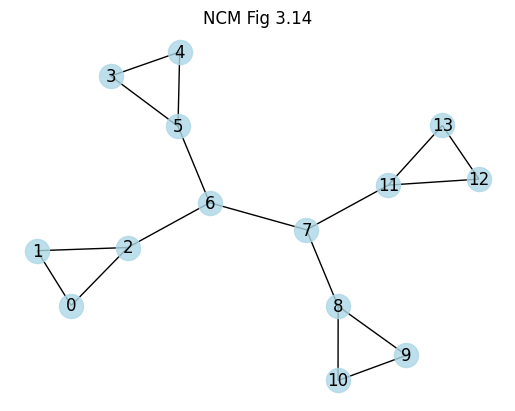

In [3]:
fig314, pos314 = get_NCM_Figure3_14()
show_partitions(fig314,
                partition = [set(), fig314.nodes()],
                pos = pos314,
                title = "NCM Fig 3.14")

Look at the Laplacian matrix and notice that the sum across rows is 0.

In [4]:
L = nx.laplacian_matrix(fig314,
                        nodelist=sorted(fig314.nodes())).toarray()
print(L)

[[ 2 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1  2 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  3  0  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  2 -1 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  2 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1 -1  3 -1  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0 -1  3 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  3 -1  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0 -1  3 -1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  2 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1 -1  2  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0  3 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  2 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  2]]


The reason that the row sum is 0 is because of the way the Laplacian is defined. Recall the definition

$$ L = D - A $$

where $D$ is the diagonal matrix made up of the (out) degree for each vertex and $A$ is the adjacency matrix. Since $D_{i,i}$ is the degree of node $i$, and since $A_{i,j}$ is $1$ for each $j$ adjacenct to $i$, $D_{i,i} = \sum_{j}A_{i,j}$. Thus, the row sum is 0.

Recall that the column vector of all ones is denoted by

$${\mathbf 1} = [1, 1, \ldots, 1] ^T$$

What is $L{\mathbf 1}$?

In [5]:
ones = np.ones((len(L),1))
print(L@ones)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


$L{\mathbf 1}$ is the vector fall zeroes. Why? Because multplying a row a matrix with the column vector of all 1's just sums up all the entries in the row. 

We can this as an equation and do a little algebra. Let ${\mathbf 0}$ denote the column vector of all 0's.

$$
    \begin{array}{rcl}
        L{\mathbf 1}    &=& {\mathbf 0} \\
                        &=& 0 {\mathbf 1}
    \end{array}
$$

Recall that the definition of an eigenvalue, eigenvector of matrix $M$ is $M{\mathbf x} = \lambda{\mathbf x}$. Observing that if ${\mathbf x} = {\mathbf 1}$ and $\lambda = 0$ tells us that the vector of all 1's is an eigenvector of $L$ with corresponding eigenvalue of 0. 

Let's inspect the eigenvalues and eigenvectors of $L$ to confirm.

In [6]:
vals, vects = np.linalg.eig(L)
print(vals)


[ 5.17740968e+00  4.41421356e+00  1.58578644e+00 -5.42747603e-17
  1.44227493e-01  2.67836283e+00  2.67949192e-01  2.67949192e-01
  3.00000000e+00  3.73205081e+00  3.73205081e+00  3.00000000e+00
  3.00000000e+00  3.00000000e+00]


If your solver acts like mine, there isn't an eigenvalue that is 0. But recall that numerical eigenvalue solvers have numerical errors. Rounding to a reasonable number of figures will mitigate these numerical errors.

In [7]:
vals = np.round(vals, 3)
print(vals)

[ 5.177  4.414  1.586 -0.     0.144  2.678  0.268  0.268  3.     3.732
  3.732  3.     3.     3.   ]


My solver gives me a -0, which is just 0. Let's find the index

In [8]:
zero_index = np.where(np.abs(vals) < 0.00001)[0]
print(zero_index)

[3]


Let's look at the corresponding eigenvector. Note that the eigenvalue solver in the numpy linear algebra library returns a vector whose columns are the eigenvectors.

In [9]:
print(vects[:,zero_index[0]])

[0.26726124 0.26726124 0.26726124 0.26726124 0.26726124 0.26726124
 0.26726124 0.26726124 0.26726124 0.26726124 0.26726124 0.26726124
 0.26726124 0.26726124]


It's not a vector of all 1's, but its a vector whose values are all equal. This is just fine since a vector whose values are all equal is just a scalar times the vector of all 1's. Let $c$ be the scalar so the vector whose values are all equal is $c{\mathbf 1}$. Plugging and chugging gives

$$ Lc{\mathbf 1} = cL{\mathbf 1} = c0{\mathbf 1} = 0{\mathbf 1}$$

so the result is the same. Let's see where we can use the observation that the vector of all 1's (or a vectors whose values are all equal) is an eigenvector of $L$.

---

#### Diffusion

Consider a building with six rooms connected by air ducts.

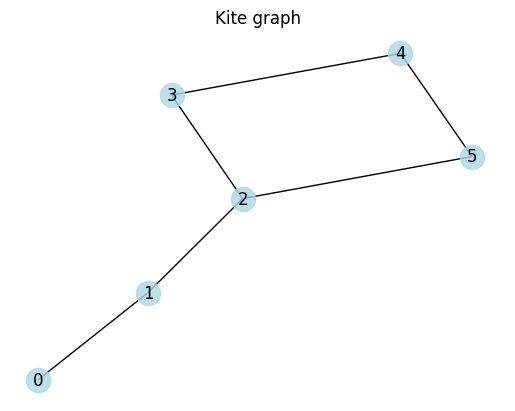

In [10]:
kitegraph, poskite = get_kite_graph()
show_partitions(kitegraph,
                partition = [set(), kitegraph.nodes()],
                pos = poskite,
                title = "Kite graph")
L_kite = nx.laplacian_matrix(kitegraph,nodelist=sorted(kitegraph.nodes()))

Suppose that we put one unit of some airborne toxin in room 0. It will help if we can animate how this toxin spreads to other rooms, so let's use the code from when we were looking at random walk centrality.

In [11]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, Hashable
from IPython import display

class Animation_Handler:
    def __init__(self,
                 G: nx.Graph,
                 node_positions: dict[Hashable, Tuple[float, float]],
                 title = "") -> None:
        self.node_positions = node_positions
        self.G = G
        self.title = title

    def init_plot(self,
                  x: np.array) -> None:
        desired_node_size = 200
        plt.figure(figsize=(3,3))
        self.ax = plt.gca()
        nx.draw(self.G,
                pos = self.node_positions,
                node_size=desired_node_size,
                node_color = x,
                cmap = 'cool',
                font_color = 'white',
                alpha=0.8,
                with_labels = True)
        self.ax.set_title(self.title)
        self.ax.axis('off')  # Turn off the axes
        self.sm = plt.cm.ScalarMappable(cmap = 'cool',
                                        norm=plt.Normalize(vmin = 0, vmax=1))
        plt.colorbar(self.sm, ax=self.ax)  # Add colorbar to the plot
    
    def update_plot(self,
                    x: np.array) -> None:
        self.ax.clear()  # Clear the previous plot
        desired_node_size = 200
        nx.draw(self.G,
                pos = self.node_positions,
                node_size=desired_node_size,
                node_color =x,
                cmap = 'cool',
                vmin=0,
                vmax = 1,
                alpha=0.8,
                with_labels = True,
                ax=self.ax)
        self.ax.set_title(self.title)
        self.ax.axis('off')  # Turn off the axes
        self.sm.set_array(x)  # Update the colorbar with new data

        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01)


Let's define a vector that says that the toxin is in room zero when we start.

In [12]:
x = np.zeros((len(kitegraph),1))
x[0] = 1
print(x)

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


**Outflow**

Let $x_i(t)$ denote how much toxin is in room $i$ at time $t$. The initial toxin is given by

$$ {\mathbf x}(0) = [1, 0, \ldots, 0]^T $$

As discussed in class, the amount of toxin flowing away from room $i$ at time $t$ over a small time window $dt$ is

$$dx_i^{\rm out}(t) = -k_ix_i(t) dt$$

where $k_i$ is the degree of room $i$. Why $k_i$? Because there are $k_i$ airducts incident to room $i$, and we assume that each air duct conducts an equal amount of toxin away from room $i$. The negative sign in the equation simply means that the toxin is flowing away from room $i$.

**Inflow**

Each room adjacent to room $i$ is also diffusing the toxin into room $i$, and we can sum these up. Since the adjacency matrix tells us which neighbors are adjacent to each other, we can write the inflow to room $i$ at time $t$ over a small time window $dt$ as

$$ dx_i^{\rm in} = \sum_j A_{ij}x_j dt $$

**Net flow**
The net flow into and out of room $i$ is

$$ \begin{array}{lcr}
    dx_i &=& dx_i^{\rm out} + dx_i^{\rm in} \\
        &=& \left(-k_i x_i + \sum_jA_{ij}x_j\right) dt
\end{array}
$$

The instantaneous rate of flow is therefore

$$ \frac{dx_i}{dt} = -k_i x_i + \sum_jA_{ij}x_j $$

which can be written in matrix form as

$$ 
\begin{array}{lcr}
    \frac{d{\mathbf x}}{dt} &=& -D{\mathbf x} + A{\mathbf x} \\
                    &=& -L{\mathbf x}
\end{array}
$$

The graph Laplacian matrix gives us the rate at which a toxin diffuses through the building! Let's animate it.

Create a gif for class using the copilot code used for showing random walk centrality.

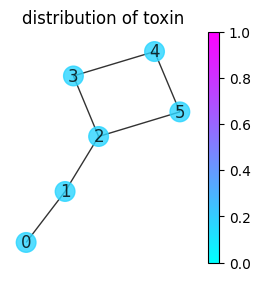

In [13]:
# Ensure the directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Initialize the animation handler
animation = Animation_Handler(kitegraph, poskite, title="distribution of toxin")

# Initialize the plot
animation.init_plot(x)

# Animation loop
i = 0
count = [i]
t = 0
dt = 0.1
duration = 15
while t <= duration:
    animation.update_plot(x)
    x = x + dt * (-L_kite @ x)
    t += dt
    # Uncomment to create gif for slides
    #plt.savefig(f"figures/frame_{i}.png")
    i += 1
    count.append(i)

In [14]:
# Uncomment to create gif for class

# import imageio

# # List of filenames
# filenames = [f'figures/frame_{i}.png' for i in count]

# # Create a GIF
# with imageio.get_writer('diffusion.gif', mode='I', duration=0.5, loop = 0) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

What is the final distribution of the toxin?

In [15]:
print(np.round(x,3))

[[0.167]
 [0.167]
 [0.167]
 [0.166]
 [0.166]
 [0.166]]


I would have needed to run it a little longer to reach equilibrium, but you get the idea. 

Here's the math. Eventually, the diffusion of the toxin stops changing, which means that $d{\mathbf x}/dt = 0$, but that means $-L{\mathbf x} = 0$, which is just the eigenvalue equation $L{\mathbf x} = 0{\mathbf x}$ where ${\mathbf x} = c{\mathbf 1}$. In other words, the eigenvector of $L$ whose values are all equal tells us the final distribution of the toxin for diffusion over a network!

---

### Number of Components

The next property of the graph Laplacian is that the number of eigenvalues with value 0 equals the number of components of the graph. Let's remove an edge from the fig3.14 graph and check.

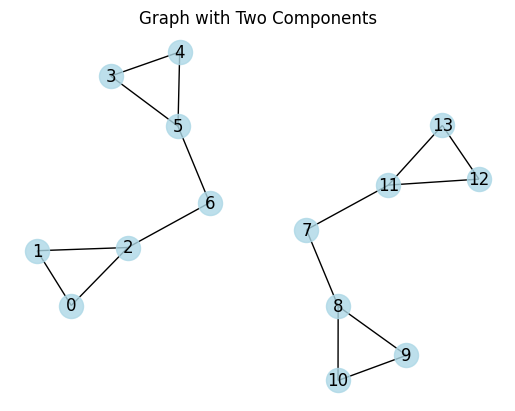

In [16]:
fig314, pos314 = get_NCM_Figure3_14()
fig314.remove_edge(6,7)
show_partitions(fig314,
                partition = [set(), fig314.nodes()],
                pos = pos314,
                title = "Graph with Two Components")

Let's inspect the graph Laplacian.

In [515]:
L = nx.laplacian_matrix(fig314, nodelist = sorted(fig314.nodes())).toarray()
print(L)

[[ 2 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1  2 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  3  0  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  2 -1 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  2 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1 -1  3 -1  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0 -1  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2 -1  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0 -1  3 -1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  2 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1 -1  2  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0  3 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  2 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  2]]


Notice the block diagonal structure! There is a block of non-zero elements in the upper left of the matrix, and a block of non-zero elements in the lower right of the matrix too. Let's look at the zero-eigenvectors of this graph Laplacian matrix.

In [516]:
vals, vects = np.linalg.eig(L)
print(f"the eigenvalues are \n\t{np.round(vals,3)}")
zero_index = np.where(np.abs(vals) < 0.00001)[0]
print(f"the eigenvalues equal to zero have indeices\n\t{zero_index}")

the eigenvalues are 
	[-0.     0.268  1.586  3.     4.414  3.732  3.     4.414  1.586 -0.
  0.268  3.732  3.     3.   ]
the eigenvalues equal to zero have indeices
	[0 9]


There are now two eigenvalues with a value of zero. Let's look at the corresponding eigenvectors.

In [517]:
for i in zero_index:
    print(f"eigenvector {i} = \n\t{vects[:,i]}")

eigenvector 0 = 
	[-0.37796447 -0.37796447 -0.37796447 -0.37796447 -0.37796447 -0.37796447
 -0.37796447  0.          0.          0.          0.          0.
  0.          0.        ]
eigenvector 9 = 
	[0.         0.         0.         0.         0.         0.
 0.         0.37796447 0.37796447 0.37796447 0.37796447 0.37796447
 0.37796447 0.37796447]


Notice how one eigenvector has a constant in the first rows and zeroes in the last rows, and the other eigenvector has the opposite pattern. We can understand what is going on by looking at what happens if we place the toxin at vertex 0 of this modified version of Figure 3.14. I'm going to place a little extra toxin to help illustrate the point.

In [518]:
x = np.zeros((len(fig314),1))
x[0] = 2
print(x)

[[2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Run the diffusion code

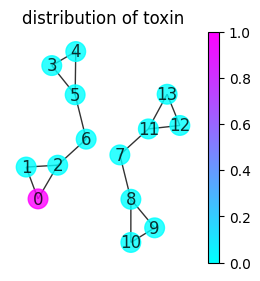

In [519]:
# Initialize the animation handler
animation = Animation_Handler(fig314, pos314, title="distribution of toxin")

# Initialize the plot
animation.init_plot(x)

# Animation loop
i = 0
count = [i]
t = 0
dt = 0.1
duration = 0*15
while t <= duration:
    animation.update_plot(x)
    x = x + dt * (-L @ x)
    t += dt
    # Uncomment to create gif for slides
    #plt.savefig(f"figures/frame_{i}.png")
    i += 1
    count.append(i)

Naturally, the toxin doesn't spread from one component of the graph to the other since there are not edges between the graphs. That's all the eigenvectors are saying. Denote the two eigenvectors with all values equal as ${\mathbf x}_1$ and ${\mathbf x}_2$. 

$$ {\mathbf x}_1 = \left[
    \begin{array}{c}
        c_1{\mathbf 1} \\ {\mathbf 0}
\end{array}
\right]
$$

$$ {\mathbf x}_1 = \left[
    \begin{array}{c}
        {\mathbf 0} \\ c_2{\mathbf 1} 
\end{array}
\right]
$$
The first eigenvector is a column of 1's on top of a column of 0's, and the second eigenvector is a column of 0's on top of a column of 1's.

**Generalizing**

We can generalize what we are seeing. I'll use the example provided by Microsoft Copilot in response to the prompt "simple proof that the number of 0 eigenvalues of the graph Laplacian equals the number of components of the graph". Copilot's proof isn't rigorous enough to satisfy a mathematician but it's good enough for the purposes of this tutorial.

Sure! Here's a simple proof that the number of zero eigenvalues of the graph Laplacian equals the number of connected components of the graph:

     Begin proof

1. **Graph Laplacian Definition**:
   The graph Laplacian $ L $ of a graph $ G $ with $ n $ vertices is defined as:
   $$
   L = D - A
   $$
   where $ D $ is the degree matrix (a diagonal matrix where each entry $ D_{ii} $ is the degree of vertex $ i $) and $ A $ is the adjacency matrix of the graph.

2. **Eigenvalues and Eigenvectors**:
   An eigenvalue $ \lambda $ of $ L $ satisfies:
   $$
   L \mathbf{v} = \lambda \mathbf{v}
   $$
   where $ \mathbf{v} $ is the corresponding eigenvector.

3. **Zero Eigenvalue**:
   For $ \lambda = 0 $, we have:
   $$
   L \mathbf{v} = 0
   $$
   This implies that $ \mathbf{v} $ is in the null space of $ L $.

4. **Connected Components**:
   Consider a graph with $ k $ connected components. We can reorder the vertices such that the adjacency matrix $ A $ and the degree matrix $ D $ are block diagonal, with each block corresponding to a connected component.

5. **Block Diagonal Form**:
   In this block diagonal form, the Laplacian $ L $ is also block diagonal:
   $$
   L = \begin{pmatrix}
   L_1 & 0 & \cdots & 0 \\
   0 & L_2 & \cdots & 0 \\
   \vdots & \vdots & \ddots & \vdots \\
   0 & 0 & \cdots & L_k
   \end{pmatrix}
   $$
   where $ L_i $ is the Laplacian of the $ i $-th connected component.

6. **Null Space of Each Block**:
   Each block $ L_i $ has a null space of dimension 1, corresponding to the eigenvector with all entries equal to 1 (since each connected component is connected, the sum of the rows of $ L_i $ is zero).

7. **Total Null Space**:
   The null space of $ L $ is the direct sum of the null spaces of each $ L_i $. Therefore, the dimension of the null space of $ L $ is $ k $, the number of connected components.

8. **Conclusion**:
   The number of zero eigenvalues of the graph Laplacian $ L $ is equal to the dimension of its null space, which is the number of connected components of the graph.

This completes the proof. 

      End proof

---
---

#### Graph Laplacian is positive semi-definite

A square matrix $M$ is called _positive semi-definite_ if 

$$ \forall {\mathbf x} \in \mathbb{R}^n\ \ \  {\mathbf x}^TM{\mathbf x} \geq 0$$

The graph Laplacian is a positive semi-definite matrix. This is a fundamental result in spectral graph theory, and several spectrum-based results follow from it. I'll give a simple proof and then interpret it means. The proof is based on the prompt to ChatGPT 4.0-Turbo "Proof that the graph Laplacian is positive semi-definite." I like the proof and will teach it in class.


     Begin proof

To prove that the **graph Laplacian** $ L $ is **positive semidefinite**, we show that for any real vector $ {\mathbf x} $, the quadratic form $ x^T L x $ is always **non-negative**, i.e.,  

$$
{\mathbf x}^T L {\mathbf x} \geq 0 \quad \text{for all } {\mathbf x} \in \mathbb{R}^n.
$$

### **Step 1: Definition of the Graph Laplacian**
The **combinatorial Laplacian** of an undirected, weighted graph $ G = (V, E) $ with $ n $ vertices is defined as:

$$
L = D - A
$$

where:
- $ D $ is the **degree matrix**, a diagonal matrix where $ D_{ii} = \sum_{j} A_{ij} $ (the sum of weights of edges incident to node $ i $).
- $ A $ is the **adjacency matrix**, where $ A_{ij} $ represents the weight of the edge between nodes $ i $ and $ j $.

### **Step 2: Quadratic Form of the Laplacian**
For any real vector $ {\mathbf x} \in \mathbb{R}^n $, we compute the quadratic form:

$$
{\mathbf x}^T L {\mathbf x} = {\mathbf x}^T (D - A) {\mathbf x}.
$$

Expanding this:

$$
{\mathbf x}^T L {\mathbf x} = {\mathbf x}^T D {\mathbf x} - {\mathbf x}^T A {\mathbf x}.
$$

Since $ D $ is diagonal, we can write:

$$
{\mathbf x}^T D {\mathbf x} = \sum_{i=1}^{n} D_{ii} x_i^2 = \sum_{i=1}^{n} \left( \sum_{j} A_{ij} \right) x_i^2.
$$

Similarly, the second term is:

$$
{\mathbf x}^T A {\mathbf x} = \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij} x_i x_j.
$$

Thus, we get:

$$
{\mathbf x}^T L {\mathbf x} = \sum_{i=1}^{n} \left( \sum_{j} A_{ij} \right) x_i^2 - \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij} x_i x_j.
$$

Rewriting the summations:

$$
{\mathbf x}^T L {\mathbf x} = \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij} (x_i^2 + x_j^2 - 2x_i x_j).
$$

Since $ (x_i - x_j)^2 = x_i^2 + x_j^2 - 2x_i x_j $, this simplifies to:

$$
{\mathbf x}^T L {\mathbf x} = \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij} (x_i - x_j)^2.
$$

### **Step 3: Non-Negativity**
- Each term $ (x_i - x_j)^2 $ is **non-negative**.
- The adjacency weights $ A_{ij} $ are **non-negative**.
- The sum is therefore **non-negative**.

Thus,

$$
x^T L x \geq 0 \quad \text{for all } x \in \mathbb{R}^n.
$$

### **Conclusion**
Since $ x^T L x \geq 0 $ for all $ x $, the Laplacian matrix $ L $ is **positive semidefinite**.

$$
L \succeq 0.
$$

This proves the result.

     End proof



Build some inituition by looking at a very simple connected graph, its Laplacian, and the product ${\mathbf x}^TL{\mathbf x}$.

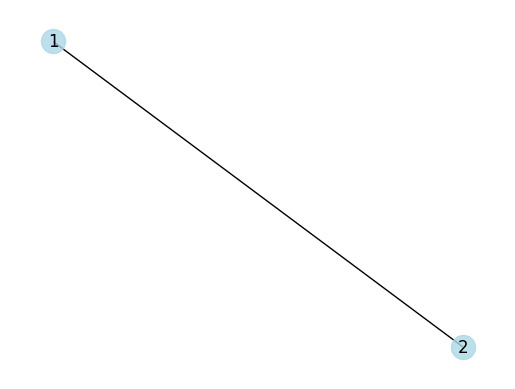

In [520]:
G = nx.Graph()
G.add_edges_from([[1,2]])
show_partitions(G,
                partition = [set(), set(G.nodes())])

Let's plot ${\mathbf x}L{\mathbf x}$ for a bunch of values of ${\mathbf x}$. Ignore the poor code quality. It's very old code.

Text(0.5, 0.92, '$x^TLx$')

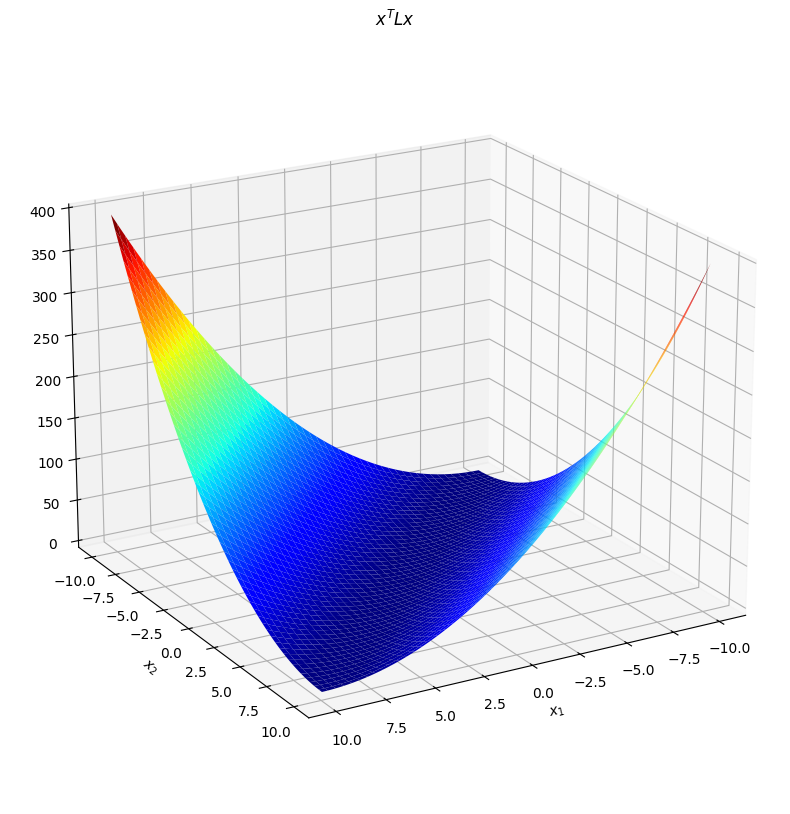

In [521]:
import matplotlib.pyplot as plt
L = nx.laplacian_matrix(G)
w = np.arange(-10,10,0.1)
v = np.arange(-10,10,0.1)
W, V  = np.meshgrid(w, v)
P = np.zeros((len(w),len(v)))
for i in range(len(w)):
    for j in range(len(v)):
        x = np.array([[W[i,j]],[V[i,j]]])
        p = np.transpose(x)@L@x
        P[i,j] = p[0,0]
fig = plt.figure(figsize =(10, 10))
ax = plt.axes(projection ='3d')
ax.plot_surface(W,V,P, cmap = plt.get_cmap('jet'), edgecolor = 'none')
ax.view_init(20, 60)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("$x^TLx$")

Notice how none of the values of the produce are negative. Indeed, the plot looks like a parabola. That parabola shape is what tells us that the product ${\mathbf x}^TL{\mathbf x}$ is non-negative. 

Look at the places where the product is zero? Notice that they occur when $x_1=x_2$. In other words, both $x_1$ and $x_2$ are some constant times one. When this occurs, we have the property that

$$ 
\begin{array}{lcr}
    {\mathbf x}L{\mathbf x} &=& [c,c] L \left[\begin{array}{c} c \\ c \end{array}\right] \\
    &=& [c,c] L \left[\begin{array}{c} 1 \\ 1 \end{array}\right]c \\
    &=& [c,c] 0 \\
\end{array}
$$

because the vector ${\mathbf 1}$ is an eigenvector of $L$ with an eigenvalue of 0. Thus, all places where $x_1=x_2$ cause the product ${\mathbf x}^TL{\mathbf x}$ to be zero. Everywhere else, the product is positive.

---

**Application: Using the eigenvectors of $L$ to visualize a network**

The following discussion is taken from Newman, "Networks", 2nd Edition, section 6.14.2.

Suppose that we want to find a good visualization of a network. stupid but useful way to do this would be to try and plot each vertex on a straight line. The visualization would only be good if we can keep the edge length between almost all vertices small. That will prevent us from having edges that reach from one end of the visualization to the other. Let's illustrate with the kite graph.

The task is to assign each vertex $i$ a scalar value $x_i$ such that the plot looks good. I'll show a plot to illustrate, and then we'll continue the discussion.

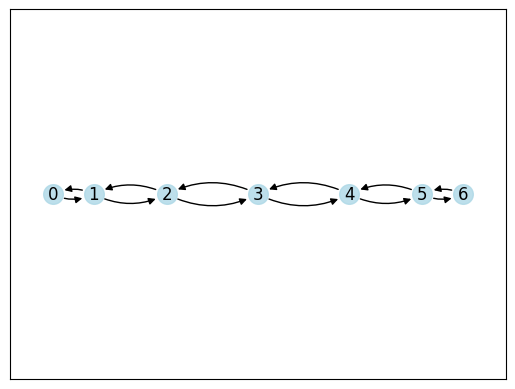

In [17]:
def plot_on_line(G: nx.Graph,
                 title = ""
                 ) -> None:
    v = nx.fiedler_vector(G)
    nodelist = list(G.nodes())
    pos: dict[Hashable, Tuple[float, float]] = dict()
    for i in range(len(G)):
        pos[nodelist[i]] = (v[i], 0)

    G_directed: nx.DiGraph = G.to_directed()

    nx.draw_networkx_nodes(G_directed,
            pos=pos,
            node_color = 'lightblue',
            node_size = 200,
            alpha = 0.8)
    nx.draw_networkx_labels(G_directed,pos)
    arc_rad = 0.25  # Radius of the arc for curved edges
    _ = nx.draw_networkx_edges(G_directed, pos, connectionstyle=f'arc3, rad = {arc_rad}')
    plt.title(title)

plot_on_line(nx.path_graph(7))

I made the graph directed by changing each undirected edge into a directed edge in each direction. Making the graph directed allowed me to bend the edges, which will help in some visualizations later in this tutorial.  

Notice how each vertex on the graph is located on the $x$-axis. That's the property we are trying to get. The next cell will formalize the idea.

The squared distance between any two nodes is $(x_i-x_j)^2$, and the sum of the squared distances between any two connected nodes is

$$ 
\begin{array}{rcl}
    \Delta^2    &=& \frac{1}{2} \sum_{i, j} A_{ij} (x_i-x_j)^2 \\
                &=& \frac{1}{2} \sum_{i, j} A_{ij}(x_i^2 - 2x_ix_j + x_j^2) \\
                &=& \frac{1}{2} \left[ \sum_i k_ix_i^2 - 2 \sum_{i,j} x_ix_j + \sum_j k_jx_j^2\right] 
                &=& \sum_{i,j} (k_i\delta_{ij} -a_{ij}) x_ix_j \\
                &=& \sum_{i,j} L_{ij}x_ix_j
\end{array}$$

where $\delta_{ij}$ is zero when $i==j$. Thus, $\Delta^2 = {\mathbf x}^T L {\mathbf x}$.



Remember that we are trying to find a way to plot vertices of a graph in a way that is visually appealing, and we came up with a metric for visual appeal which is "place nodes so that connected nodes are close together". This produced a minimization problem, namely to minimize

$$\Delta^2 = {\mathbf x}^T L {\mathbf x}$$

This minimization problem is _well-formed_ because $L$ is positive semi-definite. More specifically, we know that $\Delta^2$ is always non-negative because $L$ is positive semi-definite. 



Which values of ${\mathbf x}$ will minimize $\Delta^2$? We'll discuss this more later, but for now I'll just show you the kind of visualization you can get when you choose the eigenvectors well. 

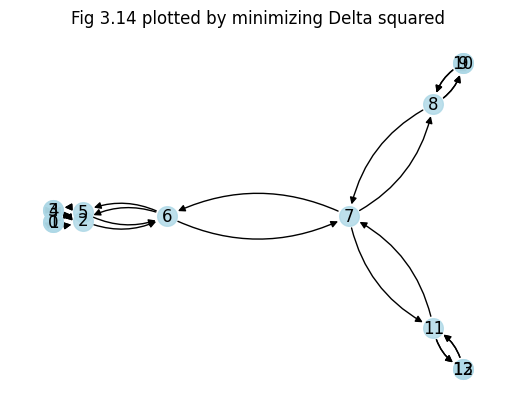

In [25]:
fig314,_ = get_NCM_Figure3_14()

def plot_in_2D(G: nx.Graph,
               title = ""
               ) -> None:
    L = nx.laplacian_matrix(G).toarray()
    vals, vecs = np.linalg.eig(L)
    sorted_indices: list[int] = np.argsort(vals)
    xi = sorted_indices[1]
    yi = sorted_indices[2]
    nodelist: list[Hashable] = list(G.nodes())
    pos: dict[int, Tuple[float, float]] = dict()
    for i in range(len(vals)):
        pos[nodelist[i]] = (vecs[i,xi], vecs[i,yi])
    G_directed: nx.DiGraph = G.to_directed()

    nx.draw_networkx_nodes(G_directed,
            pos=pos,
            node_color = 'lightblue',
            node_size = 200,
            alpha = 0.8)
    nx.draw_networkx_labels(G_directed,pos)
    arc_rad = 0.25  # Radius of the arc for curved edges
    _ = nx.draw_networkx_edges(G_directed, pos, connectionstyle=f'arc3, rad = {arc_rad}')
    plt.title(title)
    plt.axis('off')

plot_in_2D(fig314, title = "Fig 3.14 plotted by minimizing Delta squared")

It's clearly not a great plot of the figure, but it shows how nodes that share an edge are placed close to each other. Let's do it for a circulant graph to see what that looks like.

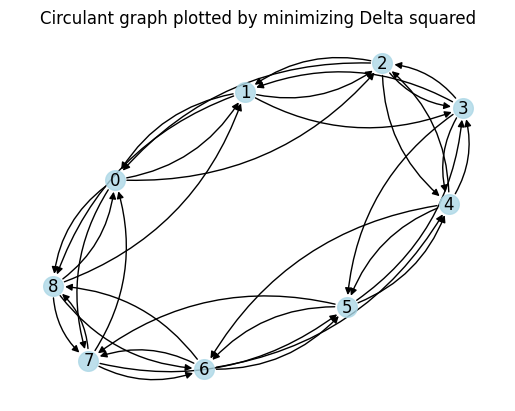

In [26]:
G = nx.circulant_graph(9,[1,2])
title = "Circulant graph plotted by minimizing Delta squared"
plot_in_2D(G, title=title)

I'll need a figure of the circulant graph for lecture, so I'll plot it using the _neato_ layout here.

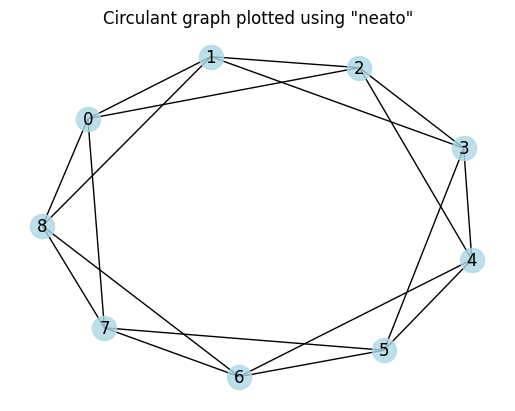

In [24]:
show_partitions(G, partition = [set(), set(G.nodes())],
                title = "Circulant graph plotted using \"neato\"")

---

**Eigenvalues and eigenvectors of $L$**

The reason that it's important to understand that $L$ is positive semi-definite is because the eigenvalues of positive semi-definite matrices have special properties. In fact, the eigenvalues and eigenvectors of $L$ are both real, and most proofs that you'll see will use the positive semi-definite property to prove that both are real.

Rather than use those proofs, I've framed prompts in Microsoft Copilot that do the proofs without relying on positive semi-definiteness. I've done this because I think they can be followed without having to understand positive semi-definiteness.

To understand the proofs, it is helpful to review the complex conjugate of an imaginary number. Let $^*$ denote the complex conjugate. The complex conjugate of an imaginary number is defined as

$$ (a + jb)^* = a-jb $$

The complex conjugate of a matrix does two things: it transposes the matrix and it takes the complex conjugate of each entry in the matrix. For a column vector, this looks like

$$ \left[
    \begin{array}{c}
        a + jb \\
        c + jd \\
        \vdots \\
        y + jz
    \end{array}
\right]^*

= \left[ 
    \begin{array}{cccc}
        a-jb & c-jd & \ldots & y - jz
    \end{array}
\right]
$$

Recall that the transpose of a product of matrices is the product of the transposes in reverse order,

$$ \left(A{\mathbf x}\right)^T = {\mathbf x}^T A^T $$

The same property applies for the complex transpose

$$ \left(A{\mathbf x}\right)^* = {\mathbf x}^* A^* $$

**Eigenvalues of $L$ are real**

Here is a valid proof I like from Copilot in response to the prompt "proof that the eigenvalues of a real symmetric matrix are real". Since $L$ is symmetric and real-valued, the proof applies to the eigenvalues of $L$. Here's Copilot's response with a modification that uses the complex transpose $^*$ instead of implicitly assuming that the standard transpose operation is the complex transpose. Note that the proof assumes that the eigenvector is non-zero since otherwise the proof is trivial. Note further that the proof uses $A$ as a generic symmetric, real matrix; the proof is not specific to the adacency matrix.


     Begin Proof

Here's a proof that the eigenvalues and eigenvectors of a symmetric matrix are real:

Let's consider a real symmetric matrix $ A $ of size $ n \times n $. This means $ A = A^* $, where $ A^* $ is the complex transpose of $ A $.

1. **Eigenvalue Equation**: Suppose $ \lambda $ is an eigenvalue of $ A $ with corresponding (non-zero) eigenvector $ \mathbf{v} $. This means:
   $$
   A \mathbf{v} = \lambda \mathbf{v}
   $$

2. **Transpose and Conjugate**: Taking the complex transpose of both sides, we get:
   $$
   (A \mathbf{v})^* = (\lambda \mathbf{v})^*
   $$
   Since $ A $ is real and symmetric, $ A^* = A $, and using the property of complex transposes, we have:
   $$
   \mathbf{v}^* A^* = \lambda \mathbf{v}^*
   $$
   Simplifying (because $A^* = A$), we get:
   $$
   \mathbf{v}^* A = \lambda \mathbf{v}^*
   $$

3. **Inner Product**: Consider the inner product $ \mathbf{v}^* A \mathbf{v} $. Using the eigenvalue equation, we have:
   $$
   \mathbf{v}^* A \mathbf{v} = \mathbf{v}^* (\lambda \mathbf{v}) = \lambda (\mathbf{v}^* \mathbf{v})
   $$
   Since $ \mathbf{v}^* \mathbf{v} $ is a scalar (specifically, the dot product of $ \mathbf{v} $ with the complex conjugate of itself), it is real and non-negative.

4. **Symmetry and Real Values**: On the other hand, using the symmetry of $ A = A^*$, we have:
   $$
   \mathbf{v}^* A \mathbf{v} = (A \mathbf{v})^* \mathbf{v} = (\lambda \mathbf{v})^* \mathbf{v} = \lambda^* (\mathbf{v}^* \mathbf{v})
   $$
   where $ \lambda^* $ is the complex conjugate of $ \lambda $.

5. **Equality of Real Parts**: Since $ \mathbf{v}^* A \mathbf{v} $ is real, we equate the two expressions:
   $$
   \lambda (\mathbf{v}^* \mathbf{v}) = \lambda^* (\mathbf{v}^* \mathbf{v})
   $$
   Given that $ \mathbf{v}^* \mathbf{v} \neq 0 $ (which we assumed), we can divide both sides by $ \mathbf{v}^* \mathbf{v} $:
   $$
   \lambda = \lambda^*
   $$

6. **Conclusion**: Since $ \lambda $ is equal to its complex conjugate, $ \lambda $ must be real.

Therefore, the eigenvalues of a symmetric matrix are real. The corresponding eigenvectors can also be chosen to be real.

     End Proof
   

In [529]:
## Look at the eigenvalues of $L$ for the kite graph
kitegraph, _ = get_kite_graph()
L_kite = nx.laplacian_matrix(kitegraph).toarray()
vals, vecs = np.linalg.eig(L_kite)
for i in range(len(vals)):
    print(f"eigenvalue {i} is {np.round(vals[i],2)}")


eigenvalue 0 is 0.0
eigenvalue 1 is 0.44
eigenvalue 2 is 4.56
eigenvalue 3 is 2.0
eigenvalue 4 is 3.0
eigenvalue 5 is 2.0


They are all real. Yay!

---

**Eigenvalues of $L$ are non-negative**

Copilot prompt is "roof that the eigenvalues of the graph laplacian are non-negative". I've change some notation and added some steps that I think are helpful.

     Begin Proof

Here's a proof that the eigenvalues of the graph Laplacian are non-negative:

**Graph Laplacian Definition**
For a graph $ G $ with $ n $ vertices, the graph Laplacian $ L $ is defined as:
$$
L = D - A
$$
where $ D $ is the degree matrix (a diagonal matrix where $ D_{ii} $ is the degree of vertex $ i $) and $ A $ is the adjacency matrix of the graph.

**Eigenvalue Equation**
Consider the eigenvalue equation for the Laplacian:
$$
L \mathbf{v} = \lambda \mathbf{v}
$$
where $ \lambda $ is an eigenvalue and $ \mathbf{v} $ is the corresponding eigenvector.

**Quadratic Form**
To show that the eigenvalues are non-negative, we use the quadratic form associated with the Laplacian:
$$
\mathbf{v}^T L \mathbf{v}
$$
Substituting $ L = D - A $, we get:
$$
\mathbf{v}^T L \mathbf{v} = \mathbf{v}^T (D - A) \mathbf{v} = \mathbf{v}^T D \mathbf{v} - \mathbf{v}^T A \mathbf{v}
$$

**Degree Matrix Contribution**
The term $ \mathbf{v}^T D \mathbf{v} $ is:
$$
\mathbf{v}^T D \mathbf{v} = \sum_{i=1}^n D_{ii} v_i^2 = \sum_{i=1}^n k_i v_i^2
$$
where $ \text{deg}(i) $ is the degree of vertex $ i $ and $ v_i $ is the $ i $-th component of $ \mathbf{v} $.

**Adjacency Matrix Contribution**
The term $ \mathbf{v}^T A \mathbf{v} $ is:
$$
\mathbf{v}^T A \mathbf{v} = \sum_{i=1}^n \sum_{j=1}^n A_{ij} v_i v_j
$$
where $ A_{ij} $ is the entry of the adjacency matrix, which is 1 if there is an edge between vertices $ i $ and $ j $, and 0 otherwise.

**Combining Terms**
Combining these terms, we get:
$$
\mathbf{v}^T L \mathbf{v} = \sum_{i=1}^n k_i v_i^2 - \sum_{i=1}^n \sum_{j=1}^n A_{ij} v_i v_j
$$
where $k_i$ is the degree of vertex $i$.

**Rewriting the Sum**
We can rewrite the double sum as:
$$
\sum_{i=1}^n \sum_{j=1}^n A_{ij} v_i v_j = \sum_{(i,j) \in E} 2 v_i v_j
$$
where $ E $ is the set of edges in the graph. This is because each edge $ (i,j) $ contributes twice to the sum (once as $ A_{ij} v_i v_j $ and once as $ A_{ji} v_j v_i $).

**Final Form**
Thus, we have:
$$
\mathbf{v}^T L \mathbf{v} = \sum_{i=1}^n k_i v_i^2 - \sum_{(i,j) \in E} 2 v_i v_j
$$
This can be rewritten as:
$$
\mathbf{v}^T L \mathbf{v} = \sum_{(i,j) \in E} (v_i - v_j)^2
$$

     This step is not obvious, but a follow-on prompt to Copilot convinced me


**Non-Negativity**
Since $ (v_i - v_j)^2 \geq 0 $ for all $ i $ and $ j $, it follows that:
$$
\mathbf{v}^T L \mathbf{v} \geq 0
$$

**Conclusion**
Therefore, for any eigenvector $ \mathbf{v} $, the corresponding eigenvalue $ \lambda $ satisfies:
$$
\lambda = \frac{\mathbf{v}^T L \mathbf{v}}{\mathbf{v}^T \mathbf{v}} \geq 0
$$

This proves that the eigenvalues of the graph Laplacian are non-negative. 

     End Proof


In [543]:
## Look at the eigenvalues of $L$ for the kite graph
kitegraph, _ = get_kite_graph()
L_kite = nx.laplacian_matrix(kitegraph).toarray()
vals, vecs = np.linalg.eig(L_kite)
for i in range(len(vals)):
    print(f"eigenvalue {i} is {np.round(vals[i],2)}")

eigenvalue 0 is 0.0
eigenvalue 1 is 0.44
eigenvalue 2 is 4.56
eigenvalue 3 is 2.0
eigenvalue 4 is 3.0
eigenvalue 5 is 2.0


The eigenvalues are all non-negative. Yay!

---

**Eigenvectors of $L$ are real**

We will actually be proving something different, namely that that the eigenvectors of $L$ can be chosen to be real. Here's a valid proof from Copilot in response to the prompt "proof that the eigenvectors of a real symmetric matrix can be chosen as real". I've modified the proof by adding a few statements to help make each step more clear and to use the complex conjugate notation $^*$ instead of what it used. Note that the proof assumes that the eigenvalues of the matrix are real, which we've already proven.

     Begin Proof

Here's a detailed proof that the eigenvectors of a real symmetric matrix can be chosen to be real:

1. **Eigenvalue Equation**: Consider a real symmetric matrix $ A $ and its eigenvalue equation:
   $$
   A \mathbf{v} = \lambda \mathbf{v}
   $$
   where $ \lambda $ is a real eigenvalue and $ \mathbf{v} $ is the corresponding eigenvector.

2. **Complex Conjugate**: If $ \mathbf{v} $ is a complex eigenvector, then its complex conjugate $ {\mathbf v}^* $ is also an eigenvector of $ A $ with the same eigenvalue $ \lambda $. This follows from:
   $$
   A {\mathbf v}^* = \left(A \mathbf{v}\right)^* = \left(\lambda \mathbf{v}\right)^* = \lambda {\mathbf v}^*
   $$

3. **Real and Imaginary Parts**: Write the complex eigenvector $ \mathbf{v} $ as:
   $$
   \mathbf{v} = \mathbf{u} + i \mathbf{w}
   $$
   where $ \mathbf{u} $ and $ \mathbf{w} $ are real vectors representing the real and imaginary parts of $ \mathbf{v} $, respectively.

4. **Substitute into Eigenvalue Equation**: Substitute $ \mathbf{v} = \mathbf{u} + i \mathbf{w} $ into the eigenvalue equation:
   $$
   A (\mathbf{u} + i \mathbf{w}) = \lambda (\mathbf{u} + i \mathbf{w})
   $$
   Distributing $A$ across the real and imaginary parts, we get:
   $$
   A \mathbf{u} + i A \mathbf{w} = \lambda \mathbf{u} + i \lambda \mathbf{w}
   $$

5. **Equating Real and Imaginary Parts**: This implies two separate equations:
   $$
   A \mathbf{u} = \lambda \mathbf{u}
   $$
   $$
   A \mathbf{w} = \lambda \mathbf{w}
   $$

6. **Conclusion**: Both $ \mathbf{u} $ and $ \mathbf{w} $ are real eigenvectors corresponding to the real eigenvalue $ \lambda $. Therefore, any complex eigenvector can be decomposed into real eigenvectors.

Thus, we can always choose the eigenvectors of a real symmetric matrix to be real.

     End Proof


In [531]:
## Look at the eigenvectors of $L$ for the kite graph
kitegraph, _ = get_kite_graph()
L_kite = nx.laplacian_matrix(kitegraph).toarray()
vals, vecs = np.linalg.eig(L_kite)
for i in range(len(vals)):
    print(f"eigenvector {i} is {np.round(vecs[:,i],2)}")

eigenvector 0 is [0.41 0.41 0.41 0.41 0.41 0.41]
eigenvector 1 is [-0.7  -0.39  0.09  0.31  0.39  0.31]
eigenvector 2 is [-0.09  0.31 -0.7   0.39 -0.31  0.39]
eigenvector 3 is [ 0.5 -0.5 -0.5 -0.   0.5 -0. ]
eigenvector 4 is [ 0.29 -0.58  0.29  0.29 -0.58  0.29]
eigenvector 5 is [-0.    0.    0.   -0.71  0.    0.71]


They are all real. Yay!  The linear algebra eigenvalue solver in numpy returns real eigenvectors if it can. 

---

#### Using the eigenvectors of $L$ to visualize a network

The following discussion is taken from Newman, "Networks", 2nd Edition, section 6.14.2.

Suppose that we want to find a good visualization of a network. stupid but useful way to do this would be to try and plot each vertex on a straight line. The visualization would only be good if we can keep the edge length between almost all vertices small. That will prevent us from having edges that reach from one end of the visualization to the other. Let's illustrate with the kite graph.

The task is to assign each vertex $i$ a scalar value $x_i$ such that the plot looks good. I'll show a plot to illustrate, and then we'll continue the discussion.

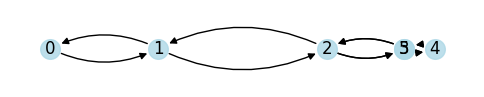

In [96]:
def plot_on_line(G: nx.Graph,
                 title = ""
                 ) -> None:
    L = nx.laplacian_matrix(G).toarray()
    vals, vecs = np.linalg.eig(L)
    sorted_indices: list[int] = np.argsort(vals)
    xi = sorted_indices[1]
    nodelist: list[Hashable] = list(G.nodes())
    pos: dict[int, Tuple[float, float]] = dict()
    for i in range(len(vals)):
        pos[nodelist[i]] = (vecs[i,xi], 0)
    G_directed: nx.DiGraph = G.to_directed()

    plt.figure(figsize=(6,1))
    nx.draw_networkx_nodes(G_directed,
            pos=pos,
            node_color = 'lightblue',
            node_size = 200,
            alpha = 0.8)
    nx.draw_networkx_labels(G_directed,pos)
    arc_rad = 0.25  # Radius of the arc for curved edges
    _ = nx.draw_networkx_edges(G_directed, pos, connectionstyle=f'arc3, rad = {arc_rad}')
    plt.title(title)
    plt.axis('off')

plot_on_line(kitegraph)

The squared distance between any two nodes is $(x_i-x_j)^2$, and the sum of the squared distances between any two connected nodes is

$$ 
\begin{array}{rcl}
    \Delta^2    &=& \frac{1}{2} \sum_{i, j} A_{ij} (x_i-x_j)^2 \\
                &=& \frac{1}{2} \sum_{i, j} A_{ij}(x_i^2 - 2x_ix_j + x_j^2) \\
                &=& \frac{1}{2} \left[ \sum_i k_ix_i^2 - 2 \sum_{i,j} x_ix_j + \sum_j k_jx_j^2\right] 
                &=& \sum_{i,j} (k_i\delta_{ij} -a_{ij}) x_ix_j \\
                &=& \sum_{i,j} L_{ij}x_ix_j
\end{array}$$

where $\delta_{ij}$ is zero when $i==j$. Thus, $\Delta^2 = {\mathbf x}^T L {\mathbf x}$.

We want to make this small so that nodes that share an edge are close to each other. The smallest eigenvalue is 0, but that's an incredibly bad choice for putting nodes on the x-axis. Thus, we are interested in the second smallest eigenvalue.

Here's the take home point. The second smallest eigenvalue gives us a lot of information about whether we can find a good way to visualize a network, where the goal is to keep nodes that are connected to each other close to each other.

---

**Algebraic Connectivity**

The second smallest eigenvalue of the graph Laplacian is called the _algebraid connectivity_ or the _Fiedler value_. It pops up in may surprising contexts, not just the visualization context. Let's illustrate how its value predicts how well we can visualize a few networks.

**Path graph:** The path graph should be easy to visualize on a line. It's algebraic connectivity should be low.

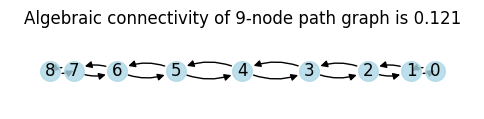

In [97]:
G = nx.path_graph(9)
title = f"Algebraic connectivity of 9-node path graph is {np.round(nx.algebraic_connectivity(G),3)}"
plot_on_line(G, title=title)

**A circulant graph:** A circulant graph should not be easy to visualize on a line. It's algebraic connectivity should not be low.

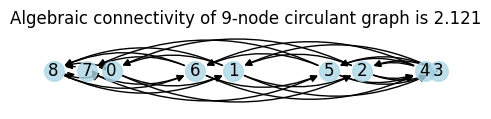

In [98]:
G = nx.circulant_graph(9,[1,2])
title = f"Algebraic connectivity of 9-node circulant graph is {np.round(nx.algebraic_connectivity(G),3)}"
plot_on_line(G, title=title)

**Complete graph:** The complete graph should not look good if visualized on a line. It's algebraic connectivity should be high.

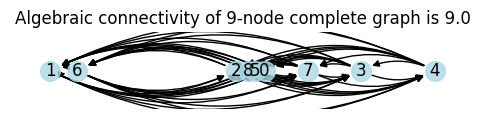

In [99]:
G = nx.complete_graph(9)
title = f"Algebraic connectivity of 9-node complete graph is {np.round(nx.algebraic_connectivity(G),3)}"
plot_on_line(G, title=title)

Notice how our intuition matches the value of algebraic connectivity. 

- path graphs should be easy to plot on a single line 
- circulant graphs should be harder
- complete graphs should be really hard

We'll return to visualization in a subsequent lecture.